# Increasing average bill AB test

We run a website that sells construction tools. The owner wants to add an option to buy an extended warranty for tools. This is a new paid add-on shown as an extra payment button on the checkout page.

We split users into two groups:

- Control: users who do not see the new payment button

- Treatment: users who see the new payment button

We will test hypothesis:

$H_o$ - There is no difference in an average bill between treatment and control groups.

$H_a$ - There is a difference in an average bill between treatment and control groups.

# Data

We will use DGP from causalis

In [1]:
from causalis.scenarios.classic_rct.dgp import classic_rct_gamma_26
from causalis.data_contracts import CausalData

data = classic_rct_gamma_26(return_causal_data=False)
data.head()

,user_id,y,d,platform_ios,country_usa,source_paid,age,cnt_trans,platform_Android,platform_iOS,invited_friend
0,00c01,62.015001,0.0,1.0,0.0,1.0,39,0,0,1,0
1,014d7,22.353186,1.0,0.0,0.0,1.0,46,4,0,1,0
2,01daa,38.213100,0.0,1.0,1.0,0.0,36,1,1,0,0
3,012b9,77.927095,1.0,1.0,1.0,0.0,26,2,0,1,0
4,00e7b,24.936085,1.0,0.0,1.0,0.0,35,3,0,1,0


In [2]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['platform_ios', 'country_usa', 'source_paid'],
                        user_id = 'user_id'
                        )
causaldata

CausalData(df=(10000, 6), treatment='d', outcome='y', confounders=['platform_ios', 'country_usa', 'source_paid'], user_id='user_id')

In [3]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,4955,45.271228,36.185063,0.338380,11.081530,20.326602,35.784254,60.063958,89.576241,431.357219
1,1.0,5045,50.328883,38.802710,0.448255,12.335521,22.792900,41.149396,67.409299,100.121519,401.883422


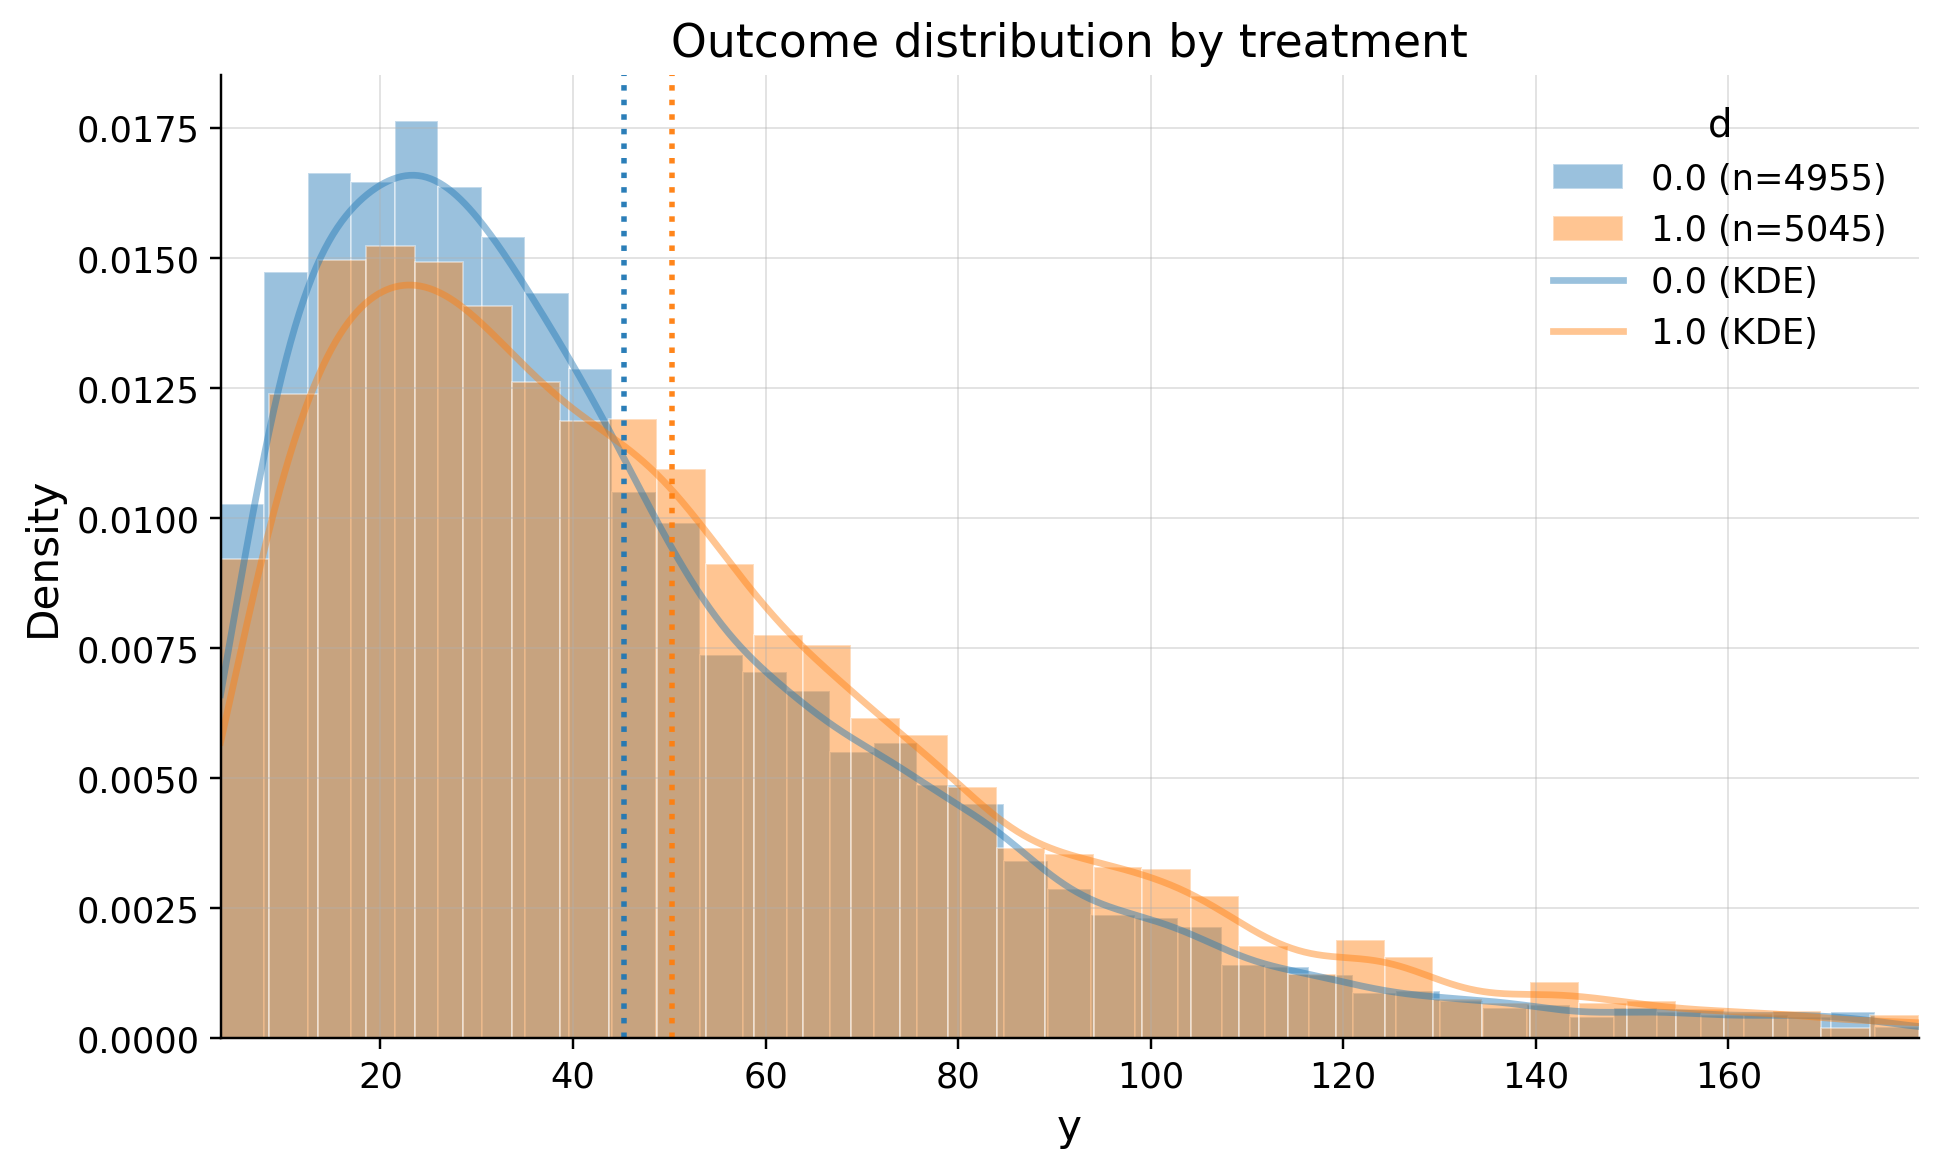

In [4]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

In [5]:
from causalis.shared import outcome_outliers

outcome_outliers(causaldata, method="iqr")

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,0.0,4955,206,0.041574,-39.279431,119.669992,True,iqr,both
1,1.0,5045,193,0.038256,-44.131698,134.333897,True,iqr,both


# Monitoring

Our system is randomly splitting users. Half of them must have new onboarding, other half has not. We should monitor the split with SRM test. Read more at https://causalis.causalcraft.com/articles/srm

In [6]:
from causalis.shared import check_srm

check_srm(assignments=causaldata, target_allocation={0: 0.5, 1: 0.5}, alpha=0.001)

SRMResult(status=no SRM, p_value=0.36812, chi2=0.8100)

## Check the confounders balance

Are groups equal in terms of confounders? We need to choose with domain and business sense confounders and check balance of them.
The standard benchmark:

- $SMD > 0.1$
- `ks_pvalue` < 0.05

In [7]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,source_paid,0.299092,0.313776,0.014684,0.031853,0.64592
1,platform_ios,0.494046,0.502874,0.008828,0.017654,0.98861
2,country_usa,0.586276,0.591873,0.005597,0.011374,1.00000


As we see system splitted users randomly

# Estimation with Diff-in-Means

In [8]:
from causalis.scenarios.classic_rct.model import DiffInMeans

model = DiffInMeans().fit(causaldata)

In [9]:
result_bootstrap = model.estimate('bootstrap')
result_bootstrap.summary()

,value
field,
estimand,ATE
model,DiffInMeans
value,"5.0577 (ci_abs: 3.6104, 6.5552)"
value_relative,"11.1719 (ci_rel: 7.7490, 14.5948)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,5045
n_control,4955


# Executive summary

We observed a statistically significant increase in average order value from 45.2 to 50.3 dollars (+ 5.06). The 95% confidence interval for the absolute lift is [3.59, 6.51].

The decision is whether to roll out this change (scale it to all users).